In [1]:
# ## 1. Library
import tensorflow as tf
import numpy as np
import os
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# ## 2. datasets, parameter control
base_dir = r'C:\Users\stmph\Pops-and-Balloons\Medical-AI-ML\Pneumonia_Chast-X-ray\chest_xray'
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32
EPOCHS = 50

In [5]:
# ## 3. Data Preprocessing & Augmentation
train_image_generator = ImageDataGenerator(
    rescale=1./255,            # 모든 픽셀 값을 0~1 사이로 정규화
    rotation_range=20,         # 20도 내에서 이미지 회전
    width_shift_range=0.1,     # 10% 내에서 좌우 이동
    height_shift_range=0.1,    # 10% 내에서 상하 이동
    shear_range=0.1,           # 10% 내에서 이미지 층밀림
    zoom_range=0.1,            # 10% 내에서 이미지 확대/축소
    horizontal_flip=True,      # 좌우 반전
    fill_mode='nearest'
)

validation_test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data_gen = validation_test_image_generator.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data_gen = validation_test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
# ## 4. CNN Model
# 4-1. Build the Model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

# 4-2. Compile the Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Users\stmph\anaconda3\envs\tf_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      21,234,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,330,881 (81.37 MB)

 Trainable params: 21,329,409 (81.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [9]:
# ## 5. Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)

history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[early_stopping, reduce_lr]
)

C:\Users\stmph\anaconda3\envs\tf_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9080 - loss: 0.2695 - val_accuracy: 0.5000 - val_loss: 3.6834 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.9419 - loss: 0.1604 - val_accuracy: 0.5000 - val_loss: 6.2486 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9438 - loss: 0.1527 - val_accuracy: 0.5000 - val_loss: 2.5303 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9492 - loss: 0.1320 - val_accuracy: 0.5000 - val_loss: 2.9960 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.9488 - loss: 0.1367 - val_accuracy: 0.5000 - val_loss: 1.5474 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.9526 - loss: 0.1306 - val_accuracy: 0.6250 - val_loss: 2.5914 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.9509 - loss: 0.

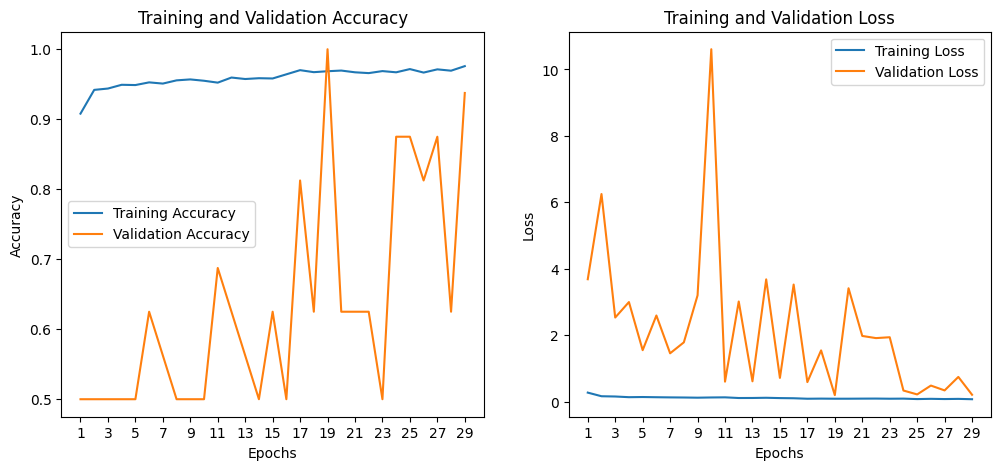

In [23]:
# ## 6. Visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

actual_epochs = len(acc)
epochs_indices = range(actual_epochs)
epochs_labels = range(1, actual_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_indices, acc, label='Training Accuracy')
plt.plot(epochs_indices, val_acc, label='Validation Accuracy')
tick_interval = 2
plt.xticks(epochs_indices[::tick_interval], epochs_labels[::tick_interval])
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_indices, loss, label='Training Loss')
plt.plot(epochs_indices, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs_indices[::tick_interval], epochs_labels[::tick_interval])

plt.show()

### 최종 모델 성능 평가 ###
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 483ms/step - accuracy: 0.9054 - loss: 0.2713
Test Loss: 0.2713
Test Accuracy: 0.9054
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 446ms/step

### 혼동 행렬 ###
[[191  43]
 [ 16 374]]


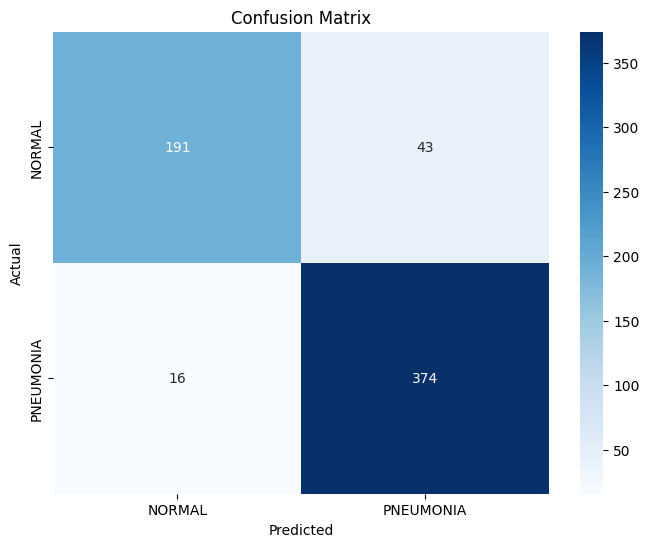


### 분류 리포트 ###
              precision    recall  f1-score   support

      NORMAL       0.92      0.82      0.87       234
   PNEUMONIA       0.90      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.89      0.90       624
weighted avg       0.91      0.91      0.90       624


### ROC AUC Curve ###
ROC AUC Score: 0.9583


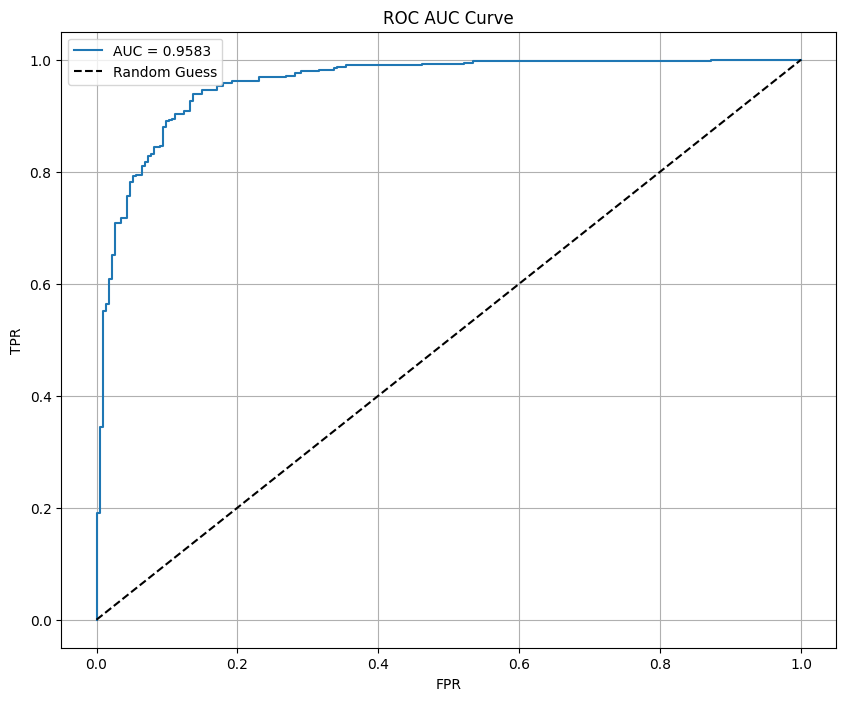

In [25]:
# ## 7. Evaluation
print("### 최종 모델 성능 평가 ###")
test_loss, test_acc = model.evaluate(test_data_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

predictions = model.predict(test_data_gen)

binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

print("\n### 혼동 행렬 ###")
cm = confusion_matrix(test_data_gen.classes, binary_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n### 분류 리포트 ###")
print(classification_report(test_data_gen.classes, binary_predictions, 
                            target_names=['NORMAL', 'PNEUMONIA']))

print("\n### ROC AUC Curve ###")
roc_auc = roc_auc_score(test_data_gen.classes, predictions)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(test_data_gen.classes, predictions)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title('ROC AUC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()